In [1]:
import random

'''
There's an 80% chance that a normal user performs an action (buy or sell).
Out of the 80%, there's a 60% probability that they buy and 40% probability that they sell.
'''
def user_action():
    # probability that the user performs an action (either buy or sell)
    buy_sell_prob = 0.8
    # probability that the user doesn't perform any action
    pass_prob = 1 - buy_sell_prob
    action = random.choices(['buy', 'sell', 'pass'], [buy_sell_prob, buy_sell_prob, pass_prob])[0]
    if action in ['buy', 'sell']:
        buy_prob = 0.6
        sell_prob = 0.4
        action = random.choices([action], [buy_prob if action == 'buy' else sell_prob])[0]
    return action

In [2]:
'''
Generate price data with an initial price of 1000.
min_vol and max_vol are the min and max volatilities
between each consecutive value.
'''
def generate_price_data(n, min_vol, max_vol):
    prices = [1000]
    for i in range(n-1):
        volatility = random.uniform(min_vol, max_vol) * random.choice([-1, 1])
        prices += [prices[i]*(1+volatility)]
    return prices

In [3]:
from amms.xrpl.amm.actions import Swap
from amms.xrpl.amm.env import User
from amms.uniswap.uniswap import Uniswap_amm

def simulator(external_prices, xrpl_block_conf, eth_block_conf, xrpl_fees, eth_fees, safe_profit_margin, max_slippage, iterations):
    xrpl_safe_profit_margin = xrpl_fees + safe_profit_margin
    eth_safe_profit_margin = eth_fees + safe_profit_margin

    xrpl_profits_total = []
    uniswap_profits_total = []
    xrpl_arbit_txs_total = []
    uniswap_arbit_txs_total = []
    xrpl_advantage = 0
    for iteration in range(iterations):
        '''
        At each iteration, we set the users and AMMs statuses to their initial one and re-run the simulation.
        Each iteration is independent of the previous one.
        '''
        # bob = normal user on xrpl
        bob = User(user_name='bob', assets={'XRP':1000, 'ETH':1e12, 'USDC':1e12})
        # arbit = arbitrageur on xrpl
        arbit = User(user_name='arbit', assets={'XRP':1000, 'ETH':1e12, 'USDC':1e12})
        # xrpl AMM
        xrpl_amm = bob.createAMM(ammID=1, asset1='ETH', asset2='USDC', amount1=1e8, amount2=995e8)
        # initiate both bob and arbit swap objects on xrpl in order to let them make swaps
        bob_swaps = Swap(bob, xrpl_amm)
        arbit_swaps = Swap(arbit, xrpl_amm)
        # uniswap AMM
        uniswap_amm = Uniswap_amm(fee_rate=0.005, asset_A_amount=1e8, asset_B_amount=995e8, initial_LP_token_number=1e6)

        xrpl_profits = [] # profits made by the arbitrageur on xrpl (in USDC)
        xrpl_potential_profits = []
        uniswap_profits = [] # profits made by the arbitrageur on uniswap (in USDC)
        uniswap_potential_profits = []
        xrpl_arbit_txs = 0 # number of transactions made by the arbitrageur on xrpl
        uniswap_arbit_txs = 0 # number of transactions made by the arbitrageur on uniswap
        current_xrpl_txs = []
        current_uniswap_txs = []
        for i in range(len(external_prices)):
            # at every block confirmation, we update the pool statuses of both AMMs (spot prices, amounts of assets, etc...)
            # UPDATE XRPL POOL
            if i % (xrpl_block_conf-1) == 0:
                xrpl_sp_preswap = xrpl_amm.spot_price1('USDC', 'ETH')
                if len(current_xrpl_txs) > 0:
                    xrpl_txs_and_profits = list(zip(current_xrpl_txs, xrpl_potential_profits))
                    random.shuffle(xrpl_txs_and_profits)
                    current_xrpl_txs, xrpl_potential_profits = zip(*xrpl_txs_and_profits)
                    for index, tx in enumerate(current_xrpl_txs):
                        xrpl_sp = xrpl_amm.spot_price1('USDC', 'ETH')
                        if xrpl_potential_profits[index] != 0 and (xrpl_sp_preswap-xrpl_sp_preswap*max_slippage) <= xrpl_sp <= (xrpl_sp_preswap+xrpl_sp_preswap*max_slippage):
                            tx('USDC')
                            xrpl_profits += [xrpl_potential_profits[index]]
                            xrpl_arbit_txs += 1
                        else:
                            tx('USDC')
                current_xrpl_txs = []
                xrpl_potential_profits = []
                xrpl_sp = xrpl_amm.spot_price1('USDC', 'ETH')

            # UPDATE UNISWAP POOL
            if i % (eth_block_conf-1) == 0:
                uniswap_sp_preswap = uniswap_amm.check_SP_price('A')
                if len(current_uniswap_txs) > 0:
                    uniswap_txs_and_profits = list(zip(current_uniswap_txs, uniswap_potential_profits))
                    random.shuffle(uniswap_txs_and_profits)
                    current_uniswap_txs, uniswap_potential_profits = zip(*uniswap_txs_and_profits)
                    for index, tx in enumerate(current_uniswap_txs):
                        uniswap_sp = uniswap_amm.check_SP_price('A')
                        if uniswap_potential_profits[index] != 0 and (uniswap_sp_preswap-uniswap_sp_preswap*max_slippage) <= uniswap_sp <= (uniswap_sp_preswap+uniswap_sp_preswap*max_slippage):
                            tx(sp=uniswap_sp_preswap)
                            uniswap_profits += [uniswap_potential_profits[index]]
                            uniswap_arbit_txs += 1
                        else:
                            tx(sp=uniswap_sp_preswap)
                current_uniswap_txs = []
                uniswap_potential_profits = []
                uniswap_sp = uniswap_amm.check_SP_price('A')

            # NORMAL USERS TRANSACTIONS
            # simulate 50 normal users making transactions
            for j in range(50):
                action = user_action()
                if action == 'buy':
                    amount = random.uniform(0.1, 5) # user will buy between 0.1 and 5 ETH
                    current_xrpl_txs += [lambda assetIn: bob_swaps.swap_given_amount_Out(assetIn=assetIn, assetOut='ETH', amountOut=amount)]
                    current_uniswap_txs += [lambda sp: uniswap_amm.swap('A', amount, sp)]
                    xrpl_potential_profits += [0]
                    uniswap_potential_profits += [0]
                elif action == 'sell':
                    amount = random.uniform(0.1, 5) # user will sell between 0.1 and 5 ETH
                    current_xrpl_txs += [lambda assetOut: bob_swaps.swap_given_amount_Out(assetIn='ETH', assetOut=assetOut, amountOut=amount*xrpl_sp)]
                    current_uniswap_txs += [lambda sp: uniswap_amm.swap('B', amount*sp, sp)]
                    xrpl_potential_profits += [0]
                    uniswap_potential_profits += [0]

            # ARBITRAGE TRANSACTIONS
            amount = random.uniform(1, 10) # amount of ETH to swap (buy or sell)
            # XRPL
            if xrpl_sp > external_prices[i]+xrpl_safe_profit_margin:
                current_xrpl_txs += [lambda assetOut: arbit_swaps.swap_given_amount_Out(assetIn='ETH', assetOut=assetOut, amountOut=amount*xrpl_sp)]
                xrpl_potential_profits += [(xrpl_sp - external_prices[i])*amount - xrpl_fees]
            # XRPL    
            if xrpl_sp+xrpl_safe_profit_margin < external_prices[i]:
                current_xrpl_txs += [lambda assetIn: arbit_swaps.swap_given_amount_Out(assetIn=assetIn, assetOut='ETH', amountOut=amount)]
                xrpl_potential_profits += [(external_prices[i] - xrpl_sp)*amount - xrpl_fees]

            # UNISWAP
            if uniswap_sp > external_prices[i]+eth_safe_profit_margin:
                current_uniswap_txs += [lambda sp: uniswap_amm.swap('B', amount*uniswap_sp, sp)]
                uniswap_potential_profits += [(uniswap_sp - external_prices[i])*amount - eth_fees]
            # UNISWAP
            if uniswap_sp+eth_safe_profit_margin < external_prices[i]:
                current_uniswap_txs += [lambda sp: uniswap_amm.swap('A', amount, sp)]
                uniswap_potential_profits += [(external_prices[i] - uniswap_sp)*amount - eth_fees]

        xrpl_profits_total += [xrpl_profits]
        uniswap_profits_total += [uniswap_profits]
        xrpl_arbit_txs_total += [xrpl_arbit_txs]
        uniswap_arbit_txs_total += [uniswap_arbit_txs]
    
        xrpl_advantage += sum(xrpl_profits_total[iteration]) > sum(uniswap_profits_total[iteration])

    xrpl_advantage = round(xrpl_advantage/iterations*100)
    return [xrpl_profits_total, uniswap_profits_total, xrpl_arbit_txs_total, uniswap_arbit_txs_total, xrpl_advantage]

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

def display_results(sim, iterations, xrpl_fees, eth_fees):
    print('Arbitrageurs are more profitable on XRPL',f'{sim[-1]}%','of the time')

    fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(15, 10))

    x_axis = [i+1 for i in range(iterations)]
    # --- plot 1 ---
    xrpl_profits_sum = [sum(sim[0][i]) for i in range(iterations)]
    uniswap_profits_sum = [sum(sim[1][i]) for i in range(iterations)]

    ax1.plot(x_axis, xrpl_profits_sum, label='XRPL-AMM')
    ax1.plot(x_axis, uniswap_profits_sum, label='Uniswap')

    ax1.set_xlabel('Iteration')
    ax1.set_ylabel('Profits (USDC)')
    ax1.set_title('Arbitrageur profits')
    ax1.legend()
    ax1.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))

    # --- plot 2 ---
    avg_xrpl_profits = round(np.average(xrpl_profits_sum))
    avg_eth_profits = round(np.average(uniswap_profits_sum))

    x = ['XRPL', 'Ethereum']
    y = [avg_xrpl_profits, avg_eth_profits]

    ax2.bar(x, y)
    ax2.text(x[0], y[0], avg_xrpl_profits, ha='center', va='bottom')
    ax2.text(x[1], y[1], avg_eth_profits, ha='center', va='bottom')

    ax2.set_ylim(min(y)-max(y)/50, max(y)+max(y)/50)
    diff = max(y) - min(y)
    ax2.text(0.5, (max(y)+min(y))/2, f'Diff: {diff}', ha='center', va='center')
    ax2.set_ylabel('Profits (USDC)')
    ax2.set_title('Average arbitrageur profits')
    ax2.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))

    # --- plot 3 ---
    ax3.plot(x_axis, sim[2], label='XRPL-AMM')
    ax3.plot(x_axis, sim[3], label='Uniswap')

    ax3.set_xlabel('Iteration #')
    ax3.set_ylabel('Number of Transactions')
    ax3.set_title('Number of Txs made by the arbitrageur at each iteration')
    ax3.legend()
    ax3.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))

    # --- plot 4 ---
    avg_xrpl_txs = round(np.average(sim[2]))
    avg_eth_txs = round(np.average(sim[3]))

    x = ['XRPL', 'Ethereum']
    y = [avg_xrpl_txs, avg_eth_txs]

    ax4.bar(x, y)
    ax4.text(x[0], y[0], avg_xrpl_txs, ha='center', va='bottom')
    ax4.text(x[1], y[1], avg_eth_txs, ha='center', va='bottom')
    ax4.set_ylabel('# of Txs')
    ax4.set_title('Average total arbitrage Txs')
    ax4.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))

    # --- plot 5 ---
    xrpl_fees_total = [i*xrpl_fees for i in sim[2]]
    uniswap_fees_total = [i*eth_fees for i in sim[3]]

    ax5.plot(x_axis, xrpl_fees_total, label='XRPL-AMM')
    ax5.plot(x_axis, uniswap_fees_total, label='Uniswap')

    ax5.set_xlabel('Iteration #')
    ax5.set_ylabel('Cumulative Tx fees (USDC)')
    ax5.set_title('Total Tx fees paid by the arbitrageur at each iteration')
    ax5.legend()
    ax5.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))

    # --- plot 6 ---
    avg_xrpl_fees = round(np.average(xrpl_fees_total), 4)
    avg_eth_fees = round(np.average(uniswap_fees_total), 4)

    avg_xrpl_txs = round(np.average(sim[2]))
    avg_eth_txs = round(np.average(sim[3]))

    x = ['XRPL fees for \n ~'+f'{avg_xrpl_txs} txs', 'ETH fees for \n ~'+f'{avg_eth_txs} txs']
    y = [avg_xrpl_fees, avg_eth_fees]

    ax6.bar(x, y)
    ax6.text(x[0], y[0], avg_xrpl_fees, ha='center', va='bottom')
    ax6.text(x[1], y[1], avg_eth_fees, ha='center', va='bottom')
    ax6.set_ylabel('Tx fees (USDC)')
    ax6.set_title('Average total Tx fees ')
    ax6.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))


    plt.subplots_adjust(hspace=0.3, wspace=0.6)
    plt.show()

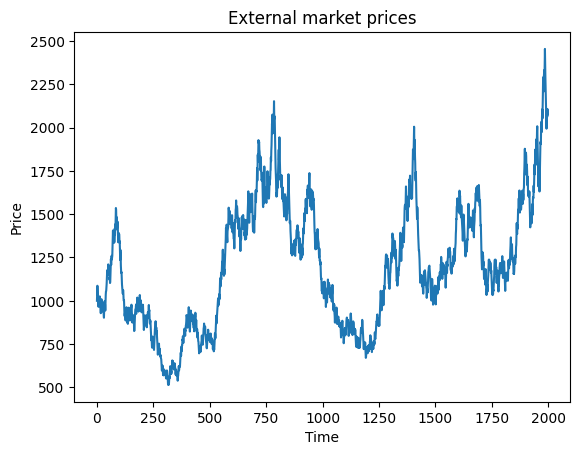

In [5]:
n_data_points = 2000
min_vol = 0.001
max_vol = 0.05
external_prices = generate_price_data(n_data_points, min_vol, max_vol)

plt.plot(external_prices)
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('External market prices')
plt.show()

Arbitrageurs are more profitable on XRPL 100% of the time


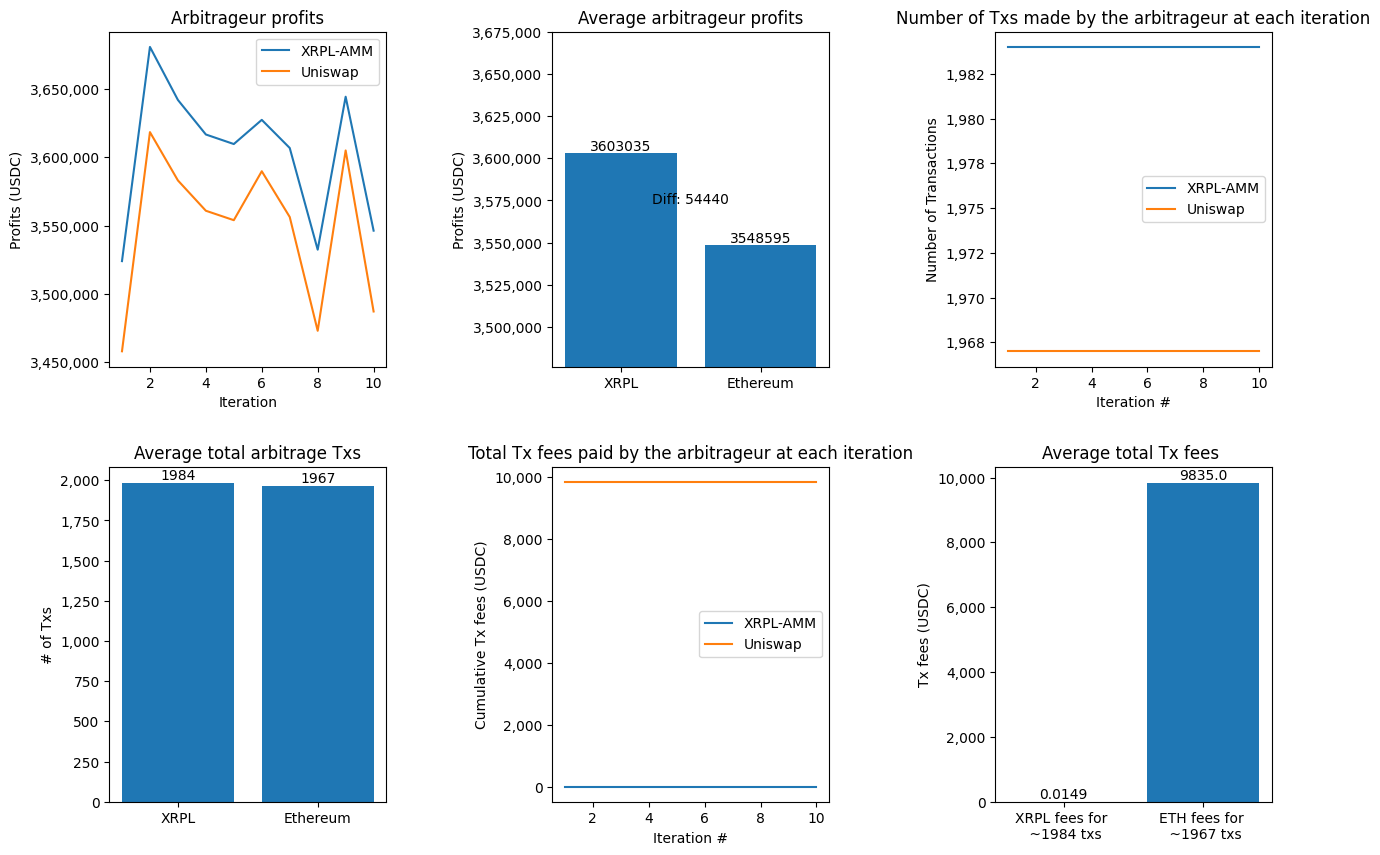

In [6]:
xrpl_block_conf = 4
eth_block_conf = 12
xrpl_fees = 0.0000075
eth_fees = 5
safe_profit_margin = 5
max_slippage = 0.03
iterations = 10

sim = simulator(external_prices, xrpl_block_conf, eth_block_conf, xrpl_fees, eth_fees, safe_profit_margin, max_slippage, iterations)
display_results(sim, iterations, xrpl_fees, eth_fees)